### Using lightgmb to model wobacon

In [129]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import json
from sklearn.metrics import make_scorer, mean_pinball_loss, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, PredefinedSplit

In [130]:
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Coding Projects/woba modeling/data')
df = pd.read_csv('pitch/pitch_cleaned.csv').drop(columns=['Unnamed: 0'])

In [131]:
df = df[df['description'] == 'hit_into_play']

##### Cleaning outliers

In [107]:
df['ev_bucket'] = pd.cut(df['launch_speed'], bins = 25)
df['la_bucket'] = pd.cut(df['launch_angle'], bins = 25)
df['combined_bucket'] = df.groupby(['ev_bucket', 'la_bucket']).ngroup()
lower_bound = df.groupby('combined_bucket')['woba_value'].transform(lambda x: x.quantile(0.03))
upper_bound = df.groupby('combined_bucket')['woba_value'].transform(lambda x: x.quantile(0.97))
df_filtered = df[(df['woba_value'] >= lower_bound) & (df['woba_value'] <= upper_bound)]
df = df_filtered.copy()

C:\Users\dalto\AppData\Local\Temp\ipykernel_30208\3962195368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['combined_bucket'] = df.groupby(['ev_bucket', 'la_bucket']).ngroup()


##### Cleaning for Task

In [132]:
df = df[df['attack_direction'].notna()] # mar, but higher substinally higher avg woba on missing. going to adress with a launch angle, launch speed model

In [133]:
df['zone'] = df['zone'].astype('category')
df['b_stands'] = df['b_stands'].map({'L': 0, 'R': 1}).astype('category')
df['year'] = pd.to_datetime(df['year']).dt.year

In [134]:
# df_train = df[df['year'] < 2025]
df_train = df
df_train = (df_train.reset_index()).drop(columns=['index'])
df_train = df_train.dropna()

In [135]:
X = (df_train[['zone', 'launch_speed', 'attack_angle', 'attack_direction', 'swing_length', 'swing_path_tilt']])
y = df_train['woba_value']

##### Train Val

no need for a test set as I am purposely holding out 2025 data. I want to test on all 2025 data to compare the predection power of this model to xwobacon

In [136]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=26) 

##### Random Search

In [137]:
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [82]:
rnd_search_params = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.01],          
    'num_leaves': np.linspace(2, 200, 25, dtype=int),
    'max_depth': np.linspace(2, 19, 7, dtype=int),  
    'min_data_in_leaf': np.linspace(1, 40, 10, dtype=int),         
    'subsample': np.linspace(0.3, 0.8, 7),               
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'n_estimators': np.linspace(100, 2000, 20, dtype=int),
    'lambda_l2': [1, 3, 5, 10, 20, 25, 50],
    'lambda_l1': [0.001, 0.01, 1, 3, 5]
}

fit_params = {
    "callbacks": [lgb.early_stopping(stopping_rounds=75, verbose=False)], 
    "eval_set": [(x_val, y_val)],
    "eval_metric": 'quantile' 
}

# for early stopping
x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
split_index = [-1] * len(x_train) + [0] * len(x_val)
pds = PredefinedSplit(test_fold=split_index)

all_best_params = {}
all_best_scores = {}

for q in quantiles:
    print(f"Running Randomized Search for quantile: {q}")

    pinball_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)

    model = lgb.LGBMRegressor(
                            alpha=q,
                            max_bin=63,
                            random_state=26,
                            n_jobs=5,
                            metric='quantile', 
                            objective='quantile')

    
    rnd_searcher = RandomizedSearchCV(model, param_distributions=rnd_search_params, cv=pds, scoring=pinball_scorer,
                                    n_iter=250, random_state=26, verbose=1, n_jobs=3) 
    
    print(model.get_params)
    search = rnd_searcher.fit(x_combined, y_combined, **fit_params)
    
    print(f"Best parameters for quantile {q}: {search.best_params_}")
    print(f"Best score for quantile {q}: {-search.best_score_}")
    
    all_best_params[q] = search.best_params_
    all_best_scores[q] = search.best_score_


Running Randomized Search for quantile: 0.05
<bound method LGBMModel.get_params of LGBMRegressor(alpha=0.05, max_bin=63, metric='quantile', n_jobs=5,
              objective='quantile', random_state=26)>
Fitting 1 folds for each of 250 candidates, totalling 250 fits


c:\Users\dalto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 224757, number of used features: 7
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_

c:\Users\dalto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 224757, number of used features: 7
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_

##### Grid Search

In [9]:
grid = {'boosting_type': ['dart', 'gbdt'],
        'subsample': [0.45, 0.5, 0.55], 
        'num_leaves':  [8, 9, 10], 
        'n_estimators': [350, 400, 450], 
        'min_data_in_leaf': [16, 18, 20], 
        'max_depth': [8, 9], 
        'max_bin': [63], 
        'learning_rate': [0.1, 0.15], 
        'lambda_l2': [0.5, 1], 
        'colsample_bytree': [0.75, 0.8]
        }


# for early stopping
x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
split_index = [-1] * len(x_train) + [0] * len(x_val)
pds = PredefinedSplit(test_fold=split_index)

fit_params = {
    "callbacks": [lgb.early_stopping(stopping_rounds=40, verbose=False)], 
    "eval_set": [(x_val, y_val)],
    "eval_metric": "rmse" 
}


grid_searcher = GridSearchCV(model, param_grid=grid, cv=pds, verbose=4, n_jobs=-1)

In [10]:
grid_searcher.fit(x_combined, y_combined, **fit_params)
print(grid_searcher.best_params_)
print(grid_searcher.best_score_)
print(grid_searcher.feature_names_in_)

Fitting 1 folds for each of 2592 candidates, totalling 2592 fits
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266
[LightGBM] [Info] Number of data points in the train set: 169715, number of used features: 5
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warni

In [17]:
grid_best = {'objective':'regression', 'type': 'quantilie', 'boosting_type': 'dart', 'colsample_bytree': 0.75, 'lambda_l2': 1, 'learning_rate': 0.15, 'max_bin': 63, 'max_depth': 8, 'min_data_in_leaf': 18, 'n_estimators': 350, 'num_leaves': 9, 'subsample': 0.45}

#### Parameters

In [91]:
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    return obj

serializable_params = convert_numpy_types(all_best_params)

with open('m2_bat_tracking.json', 'w') as f:
    json.dump(serializable_params, f, indent=4)

print("Saved best parameters")

Saved best parameters


In [138]:
with open(r'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Coding Projects/woba modeling/data/parameters/m2_bat_tracking.json', 'r') as f:
    bat_tracking_params = json.load(f)

In [ ]:
bat_tracking_params = all_best_params

#### Model Fit

In [139]:
models = {}
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
for q in quantiles:
    quantile_model = lgb.LGBMRegressor(**bat_tracking_params[str(q)], alpha=q, random_state=26, n_jobs=-1)
    quantile_model.fit(x_train, y_train, 
                       eval_set=[(x_val, y_val)], 
                       callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
    models[q] = quantile_model

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 195176, number of used features: 6
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child

##### Testing on 2025 Data

In [142]:
df_25 = df[df['year'] == 2025]
x_25 = df_25[['zone', 'launch_speed', 'attack_angle', 'attack_direction', 'swing_length', 'swing_path_tilt']]
y_25 = df_25['woba_value']

In [143]:
y_pred = models[.55].predict(x_25)
rmse = np.sqrt(mean_squared_error(y_25, y_pred))
results_df = pd.DataFrame({'actual': y_25, 'predicted': y_pred})
results_df = results_df.join(df[['batter', 'year']])
print(f'RMSE: {rmse}')

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
RMSE: 0.4918794462929094


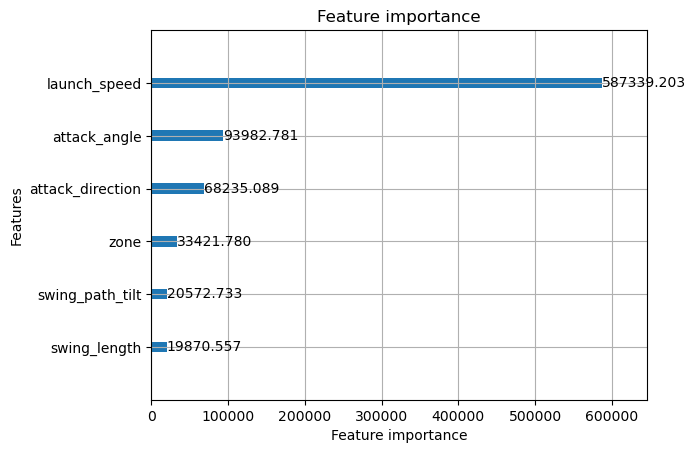

In [147]:
lgb.plot_importance(models[.55], importance_type='gain')
plt.show()

In [148]:
grouped_results = results_df.groupby(['year', 'batter'])[['actual', 'predicted']].agg(['mean', 'count'])
grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
grouped_results = grouped_results.reset_index()
grouped_rmse = np.sqrt(mean_squared_error(grouped_results['actual_mean'], grouped_results['predicted_mean']))
qualified_results = grouped_results[grouped_results['actual_count'] > 60]
qualified_rmse = np.sqrt(mean_squared_error(qualified_results['actual_mean'], qualified_results['predicted_mean']))
print(f'RMSE for batters with more than 60 plate appearances: {qualified_rmse}')
print(f'Grouped RMSE {grouped_rmse}')

RMSE for batters with more than 60 plate appearances: 0.05073652780424682
Grouped RMSE 0.11351860580635344


##### Find Quintiles for Each Data Point

In [149]:
quantile_predictions = pd.DataFrame()

for q in models:
    quantile_predictions[f'q_{q}'] = models[q].predict(x_25)

quantile_predictions.set_index(x_25.index, inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_

In [150]:
quantile_predictions['name'] = df_25['batter']
quantile_predictions['year'] = df_25['year']
quantile_cols = sorted([col for col in quantile_predictions.columns if col.startswith('q_')])
quantile_predictions[quantile_cols] = np.sort(quantile_predictions[quantile_cols].values, axis=1)
quantile_predictions[quantile_cols] = quantile_predictions[quantile_cols].clip(lower=0)

In [151]:
player_quant = quantile_predictions.groupby('name').mean()
player_quant['pitch_count'] = quantile_predictions.groupby('name').size()
player_quant['pred_std'] = player_quant[quantile_cols].std(axis=1)
player_quant = player_quant[player_quant['pitch_count'] > 60]


# Find and print the top 5 players with the highest standard deviation
print("Top 5 players with highest prediction standard deviation:")
top_5_highest_std = player_quant.nlargest(5, 'pred_std')
print(top_5_highest_std['pred_std'])

# Find and print the top 5 players with the lowest standard deviation
print("Top 5 players with lowest prediction standard deviation:")
top_5_lowest_std = player_quant.nsmallest(5, 'pred_std')
print(top_5_lowest_std['pred_std'])


Top 5 players with highest prediction standard deviation:
name
matt mervis      0.025774
riley greene     0.025663
shohei ohtani    0.024519
connor norby     0.023803
logan ohoppe     0.023684
Name: pred_std, dtype: float64
Top 5 players with lowest prediction standard deviation:
name
jake mccarthy    0.013218
kevin newman     0.013286
tyler wade       0.013484
josh rojas       0.013533
adam frazier     0.013605
Name: pred_std, dtype: float64


#### Quant Predections For Everything

In [152]:
models = {}
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
for q in quantiles:
    quantile_model = lgb.LGBMRegressor(**bat_tracking_params[str(q)], alpha=q, random_state=26, n_jobs=-1)
    quantile_model.fit(x_train, y_train, 
                       eval_set=[(x_val, y_val)], 
                       callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
    models[q] = quantile_model

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 195176, number of used features: 6
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child

In [153]:
full_predictions = pd.DataFrame()

for q in models:
    full_predictions[f'q_{q}'] = models[q].predict(X)

full_predictions.set_index(X.index, inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_

In [154]:
full_predictions['name'] = df['batter']
full_predictions['year'] = df['year']
quantile_cols = sorted([col for col in full_predictions.columns if col.startswith('q_')])
full_predictions[quantile_cols] = np.sort(full_predictions[quantile_cols].values, axis=1)
full_predictions[quantile_cols] = full_predictions[quantile_cols].clip(lower=0)
full_predictions[quantile_cols] = full_predictions[quantile_cols].clip(upper=2.01775) # average hr woba over last 8 years
full_predictions = full_predictions.reset_index()
cols = ['name', 'year'] + [col for col in full_predictions.columns if col not in ['name', 'year', 'index']]
full_predictions = full_predictions[cols]
full_predictions.to_csv('quantile_predections/bat_tracking_pitch_m2.csv')